**420-A58-SF - Algorithmes d'apprentissage non supervisé - Hiver 2023 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2023 Mikaël Swawola
<br/>
![Travaux Pratiques - Métriques de distance](static/02-02-A2-banner.png)
<br/>
**Objectif: cette séance de travaux pratiques continue le travail précédent sur la recherche de document similaires en mettant l'accent sur les métriques de distance**

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd

# Le reste des modules sera importé au fur et à mesure des exercices ...

Pour rappel, l'archive `people.zip` contient 4 fichiers:

* **people_wiki.csv**: jeu de données consituté des pages Wikipedia de personnalités
* **people_wiki_map_index_to_word.json**: mapping entre les mots et les indices
* **people_wiki_word_count.npz**: vecteurs d'occurence des mots (word count) pour chaque document
* **people_wiki_tf_idf.npz**: vecteurs TF-IDF pour chaque document

Dans l'énoncé de ce TP, les mots "article" et "document" sont interchangeables.

## 1 - Chargement des données

Ici, la **représentation TF-IDF** sera utilisée.

In [6]:
import json
from helpers import load_sparse_csr

# Chargement du jeu de données
wiki = pd.read_csv('../../data/people/people_wiki.csv')
wiki.index.name = 'id'

# Chargement des représentations TF-IDF
corpus = load_sparse_csr('../../data/people/people_wiki_tf_idf.npz')

# Chargement du mapping entre les mots et les indices
with open('../../data/people/people_wiki_map_index_to_word.json') as f:
     map_index_to_word = json.load(f)

## 2 - Choix des métriques

En regardant les résultats de l'atelier précédent, vous vous demandez peut-être pourquoi Joe Biden, colistier d'Obama lors de deux élections présidentielles, est absent des résultats de la requête de model_tf_idf. Nous allons tenter de comprendre pourquoi.

**Exercice 2-1 - Calculer la distance euclidienne entre les représentation TF-IDF de Obama et Biden**

In [23]:
# Compléter cette cellule ~ 4 lignes de code
obama_tf_idf = corpus[wiki[wiki['name'] == "Barack Obama"].index[0]]
biden_tf_idf = corpus[wiki[wiki['name'] == "Joe Biden"].index[0]]

distance = np.sqrt(np.dot((obama_tf_idf - biden_tf_idf), (obama_tf_idf-biden_tf_idf).T))
distance.toarray()

array([[123.29745601]])

**Exercice 2-2 - Calculer la longueur de chaque document Wikipédia et examiner la longueur des 100 voisins les plus proches de la page d'Obama. Il vous faudra recalculer les plus proches voisins (voir TP précédent). Pour vous aider, la fonction `compute_length` est disponible dans le fichiers `helpers.py`**

In [32]:
# Compléter cette cellule ~ 10 lignes de code
from sklearn.neighbors import NearestNeighbors
from helpers import compute_length

# Calculer les longueurs
wiki['length'] = wiki.apply(compute_length, axis=1)

# Chercher les plus proches voisins
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute').fit(corpus)
distances, indices = model_tf_idf.kneighbors(corpus[35817], n_neighbors=100)

neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()}).set_index('id')
nne = wiki.join(neighbors, on="id", how="right")[['name', 'length', 'distance']]
nne

,name,length,distance
id,,,
35817,Barack Obama,540,0.000000
7914,Phil Schiliro,208,106.861014
46811,Jeff Sessions,230,108.871674
44681,Jesse Lee (politician),216,109.045698
38376,Samantha Power,310,109.108106
...,...,...,...
9884,Kenneth M. Pollack,229,113.784257
55613,Gary D. Solis,208,113.785437
6828,George J. Mitchell,214,113.793053


Pour voir comment ces longueurs de document se comparent aux longueurs des autres documents du corpus, faisons un histogramme des longueurs de document des 100 voisins les plus proches d'Obama et comparons à un histogramme de longueurs de document pour tous les documents.

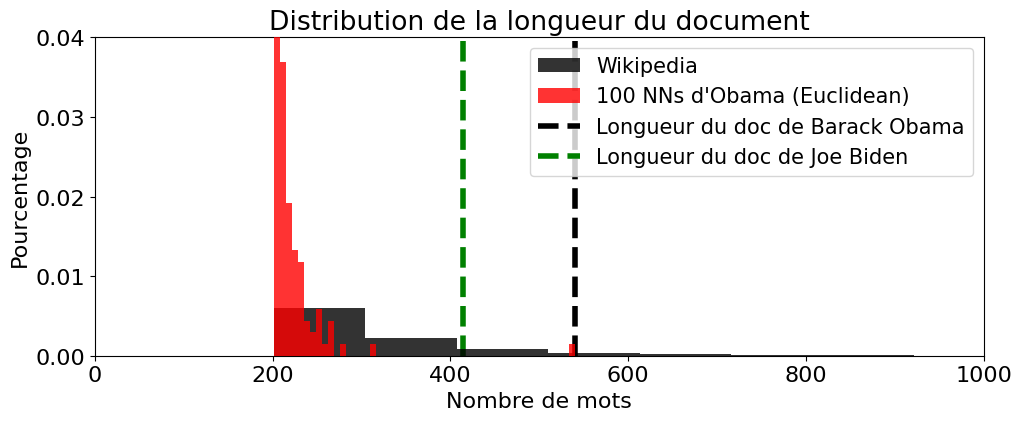

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label="100 NNs d'Obama (Euclidean)", zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Longueur du doc de Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Longueur du doc de Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution de la longueur du document')
plt.xlabel('Nombre de mots')
plt.ylabel('Pourcentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

**Exercice 2-3 - Entraîner un nouveau modèle, en prenant cette fois-ci la distance cosinus**

In [34]:
# Compléter cette cellule ~ 4-5 lignes de code
model_cosine = NearestNeighbors(algorithm='brute', metric='cosine').fit(corpus)
distances, indices = model_cosine.kneighbors(corpus[35817], n_neighbors=100)

neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()}).set_index('id')
nearest_neighbors_cosine = wiki.join(neighbors, on='id', how="inner")[['name', 'length', 'distance']].sort_values(by='distance', ascending=True)

nearest_neighbors_cosine

,name,length,distance
id,,,
35817,Barack Obama,540,0.000000
24478,Joe Biden,414,0.703139
38376,Samantha Power,310,0.742982
57108,Hillary Rodham Clinton,580,0.758358
38714,Eric Stern (politician),255,0.770561
...,...,...,...
43760,Jody Freeman,534,0.875848
28267,Michael C. Dorf,279,0.876000
48848,Greg Harris (Illinois politician),235,0.876418


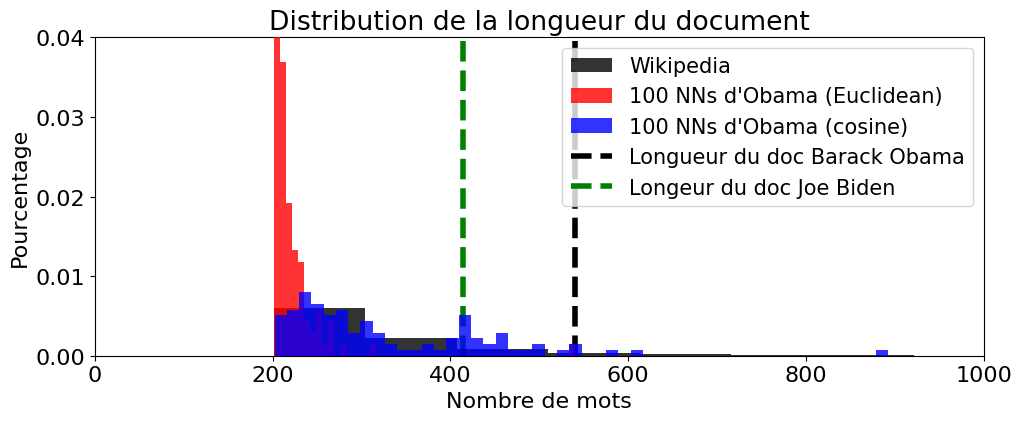

In [35]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label="100 NNs d'Obama (Euclidean)", zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label="100 NNs d'Obama (cosine)", zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Longueur du doc Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Longeur du doc Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution de la longueur du document')
plt.xlabel('Nombre de mots')
plt.ylabel('Pourcentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

## 3 - Inconvénient de la distance cosinus: tweets et articles longs

Comme vu en cours (chapitre 02-02), la **distance cosinus** peut s'avérer désavantageuse dans le cas de documents très courts et très longs. Considérons le document suivant (tweet):

In [ ]:
#+--------------------------------------------------------+
#|                                             +--------+ |
#|  One that shall not be named                | Follow | |
#|  @username                                  +--------+ |
#|                                                        |
#|  Democratic governments control law in response to     |
#|  popular act.                                          |
#|                                                        |
#|  8:05 AM - 16 May 2016                                 |
#|                                                        |
#|  Reply   Retweet (1,332)   Like (300)                  |
#|                                                        |
#+--------------------------------------------------------+

À quel point ce tweet et la page l'article Wikipedia de Barack Obama sont similaires ? La **représentation TF-IDF** de ce tweet est définie ci-dessous:

In [ ]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

**Exercice 3-1 - Visualiser les représentations TF-IDF des mots du tweets présents dans la page de Barack Obama**

In [ ]:
# Compléter cette cellule ~ 2-5 lignes de code

**Exercice 3-2: Calculer la distance cosinus entre ces deux documents**

In [ ]:
# Compléter cette cellule ~ 2-3 lignes de code

**Exercice 3-3: Comparer cette distance avec les 10 plus proches voisins trouvés à la question 2-2**

In [ ]:
# Votre réponse

## Fin de l'atelier 02-02-A2